# Tutorial 1

Design VisiumHD experiment for a colorectal cancer section

Please download according demo data from following link and place it under the demo folder:

google drive: https://drive.google.com/drive/folders/1z1nk0sF_e25LKMyHxJVMtROFjuWet2G_?usp=drive_link

Please also download the checkpoint file for the pathology foundation model and place it under the checkpoints folder

# Step 1: Preprocess the H&E image

Make sure the physical size of each pixel is 0.5 micron

Image loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/he-raw.jpg
Rescaling image (scale: 1.000)...
250 sec
../demo/Tutorial_1_VisiumHD_ROI_selection_colon/he-scaled.jpg
../demo/Tutorial_1_VisiumHD_ROI_selection_colon/he.jpg
Preprocessed H&E image saved!


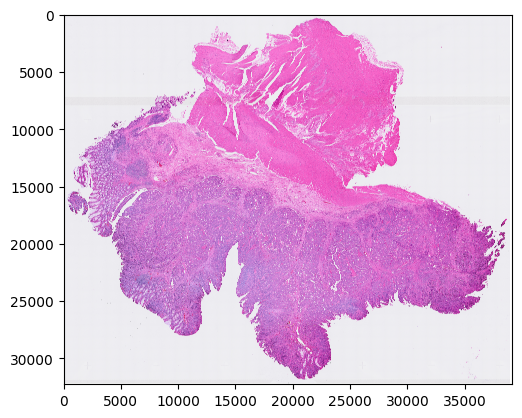

In [6]:
import sys
sys.path.append('..')
from s2omics.p1_histology_preprocess import histology_preprocess

prefix = '../demo/Tutorial_1_VisiumHD_ROI_selection_colon/'
histology_preprocess(prefix, show_image=True)

# Step 2: Quality control for all superpixels

Superpixels are 8 microns * 8 microns square-shaped pseudo cells

We use our new QC package HistoSweep for this procedure

Image loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/he.jpg
0 0
../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/shapes.pickle
[compute_metrics_memory_optimized] Current memory: 0.1839 GB; Peak memory: 3.7391 GB
[compute_low_density_mask] Current memory: 0.0046 GB; Peak memory: 0.2989 GB
Total selected for density filtering:  415494
✅ Entropy map saved as 'glcm_entropy_map_colored.png'
✅ Energy map saved as 'glcm_energy_map_colored.png'
✅ Homogeneity map saved as 'glcm_homogeneity_map_colored.png'

=== GLCM Metric Means ===
   homogeneity    energy   entropy
0     0.219866  0.030197  0.891417
1     0.482113  0.149341  0.676108
2     0.366501  0.076353  0.775128
3     0.584400  0.309048  0.559195

=== Cluster Scores ===
Cluster 0: Score = -0.6414
Cluster 1: Score = -0.0447
Cluster 2: Score = -0.3323
Cluster 3: Score = 0.3343

=== Number of Observations per Cluster ===
Cluster 0: 127419
Cluster 1: 68422
Cluster 2: 106474
Cluster 3: 31172
Total: 333

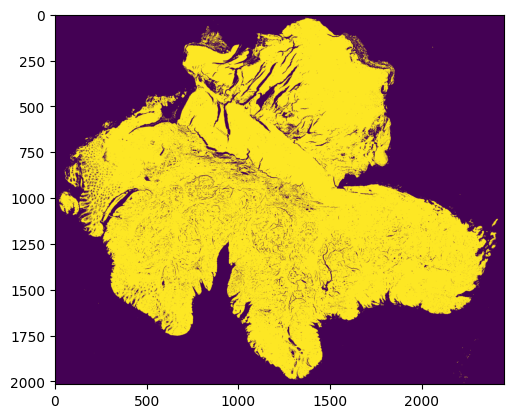

In [2]:
from s2omics.p2_superpixel_quality_control import superpixel_quality_control

save_folder = '../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output'
superpixel_quality_control(prefix, save_folder, show_image=True)

# Step 3: Histology feature extraction

In [3]:
from s2omics.p3_feature_extraction import histology_feature_extraction

# down_samp_step: the down-sampling step, 
# default = 10 refers to only extract features for superpixels whose row_index and col_index can both be divided by 10 (roughly 1:100 down-sampling rate). 
# down_samp_step = 1 means extract features for every superpixel
histology_feature_extraction(prefix, save_folder,
                             foundation_model='uni',
                             ckpt_path='../checkpoints/uni/',
                             device='cuda:0',
                             batch_size=32,
                             down_samp_step=10,
                             num_workers=4)

/data1/msyuan/anaconda3/envs/S2Omics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Histology foundation model loaded! 
    Foundation model name: uni
    Start extracting histology feature embeddings...
Image loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/he.jpg
../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/num_patches.pickle


  0%|          | 0/1547 [00:00<?, ?it/s]

Batch 0:
Shape of patches: torch.Size([32, 3, 224, 224])
Shape of positions[0]: torch.Size([32])
Content of positions[0][:10]: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Content of positions[1][:10]: tensor([   0,  160,  320,  480,  640,  800,  960, 1120, 1280, 1440])
Shape of feature_emb: torch.Size([32, 197, 1024])
Shape of patch_emb: torch.Size([32, 1024, 14, 14])


100%|█████████▉| 1546/1547 [19:26<00:00,  1.31it/s]

Part 0 patch number: 49490


100%|██████████| 1547/1547 [19:28<00:00,  1.32it/s]

../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/uni_embeddings_downsamp_10_part_0.pickle


# Step 4: Histology segmentation

Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/shapes.pickle
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/qc_preserve_indicator.pickle
Loading histology feature embeddings...
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/uni_embeddings_downsamp_10_part_0.pickle
Sucessfully loaded and normalized all histology feature embeddings!
Start segmenting the histology image, clustering method: kmeans
../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/cluster_image.pickle
../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/linkage_matrix.pickle
Segmentation image is stored at: ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/image_files/cluster_image_num_clusters_20.jpg


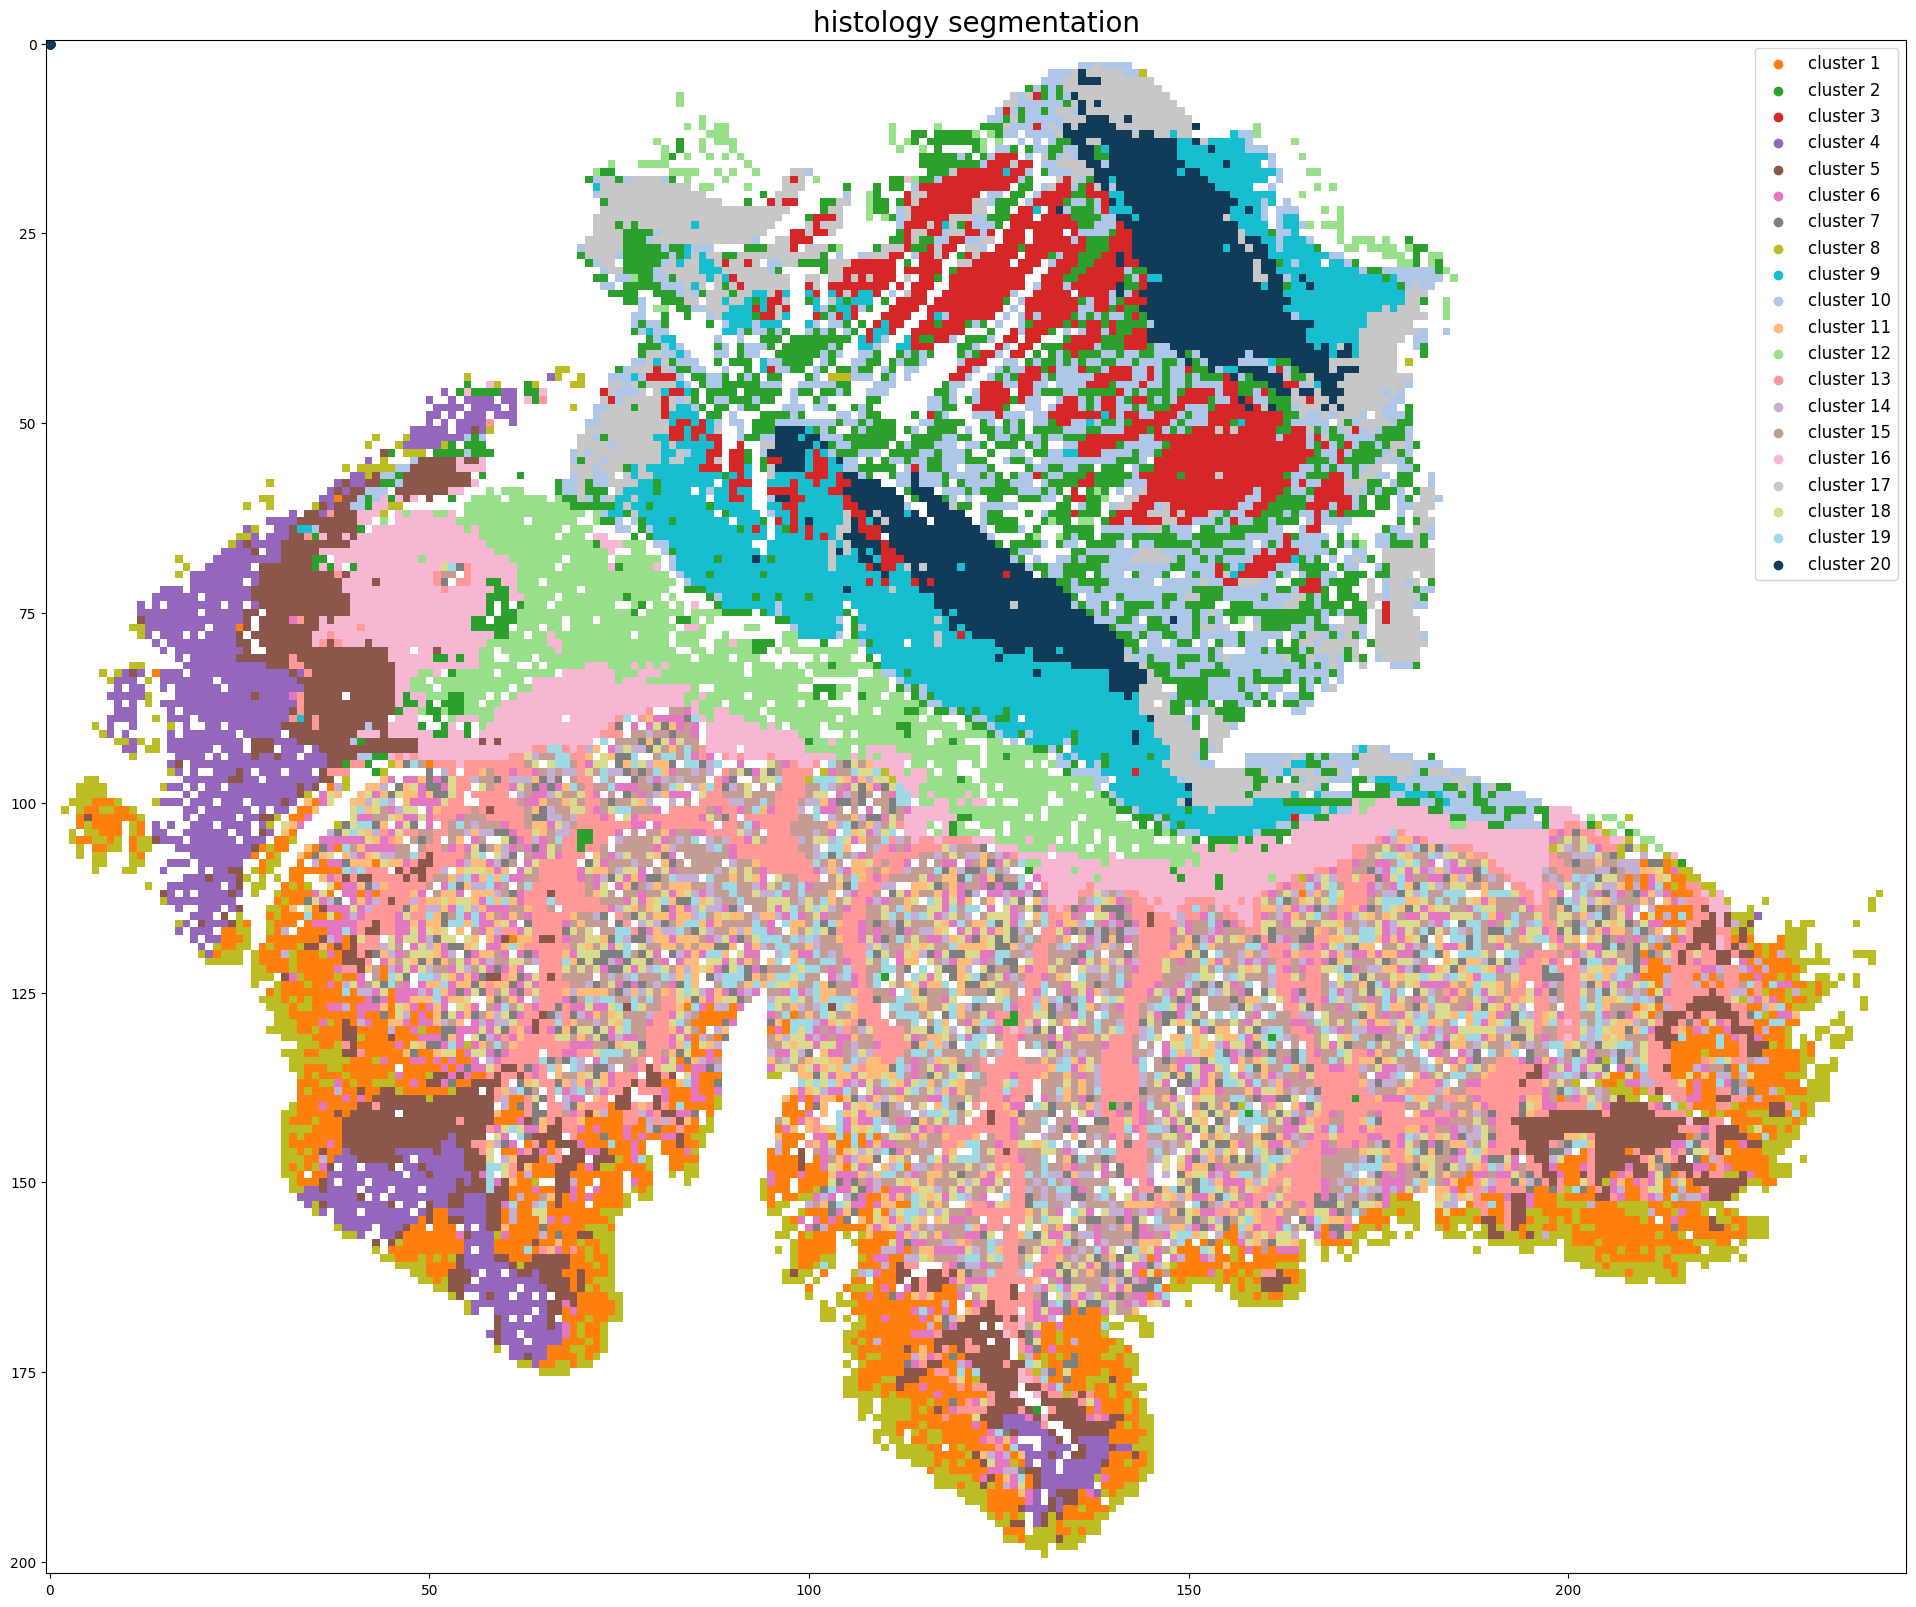

In [10]:
from s2omics.single_section.p4_get_histology_segmentation import get_histology_segmentation

get_histology_segmentation(prefix, save_folder,
                           foundation_model='uni', 
                           down_samp_step=10, 
                           clustering_method='kmeans',
                           n_clusters=20)

# Step 5: Merge over-clusters

Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/shapes.pickle
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/qc_preserve_indicator.pickle
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/cluster_image.pickle
Merging over-clusters...
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/linkage_matrix.pickle
../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/adjusted_cluster_image.pickle
Combined the original 20 clusters into 15 clusters.
Adjusted segmentation image is stored at: ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/image_files/adjusted_cluster_image_num_clusters_15.jpg


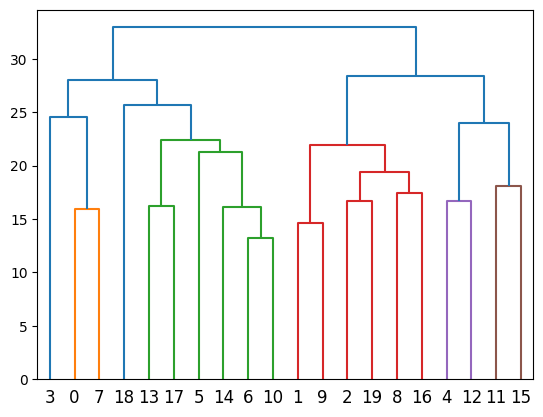

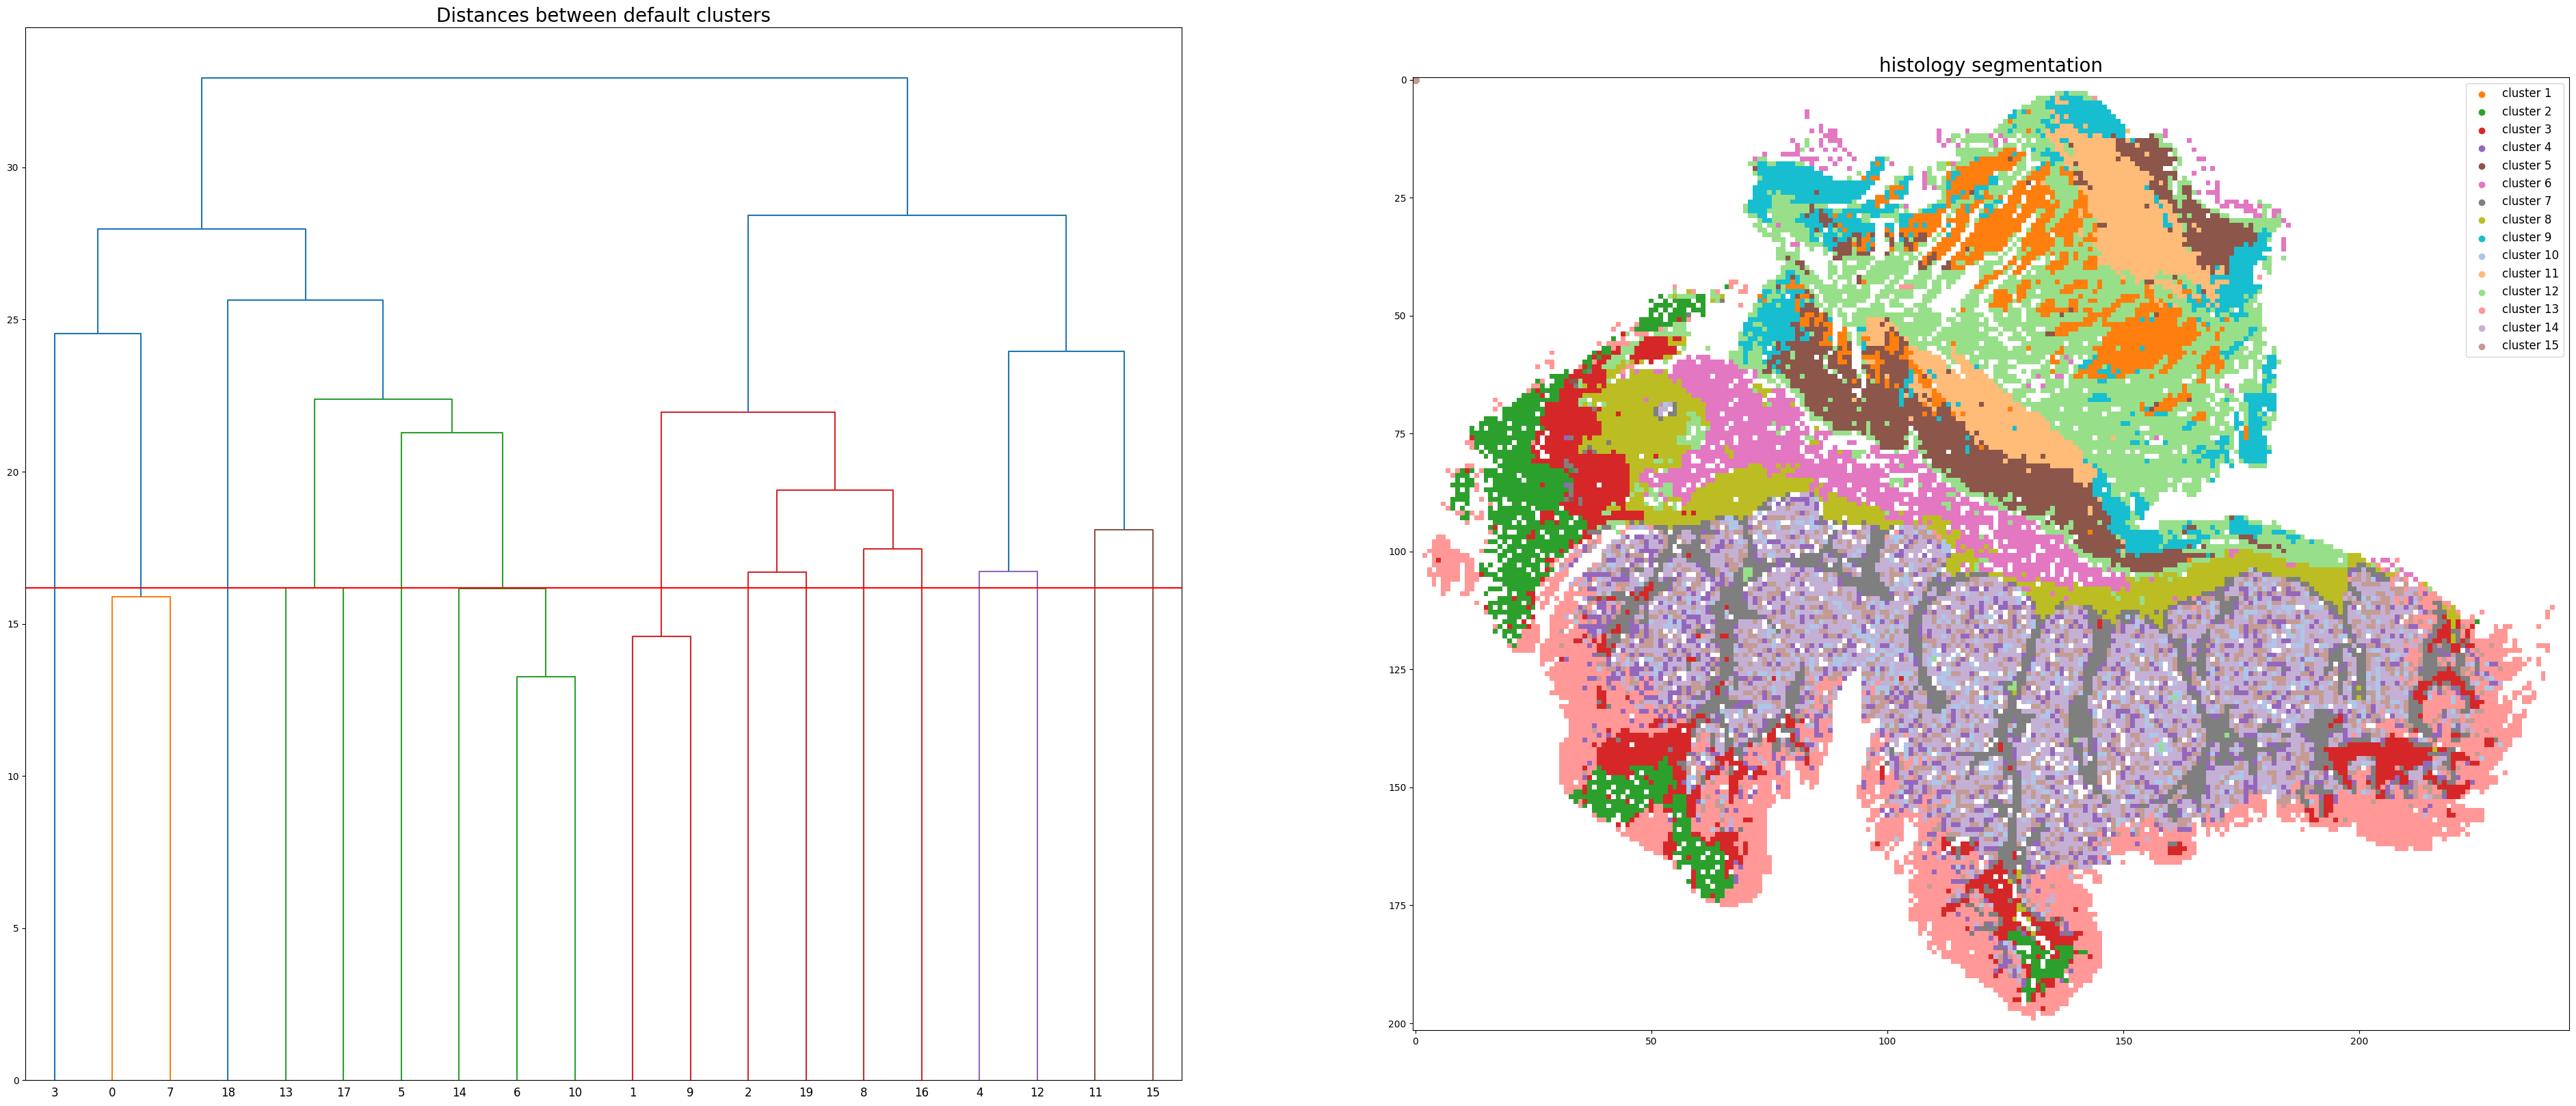

In [11]:
from s2omics.single_section.p5_merge_over_clusters import merge_over_clusters

merge_over_clusters(prefix, save_folder,
                    target_n_clusters=15)

# Step 6: Select best ROI for VisiumHD experiment

Image loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/he.jpg
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/shapes.pickle
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/qc_preserve_indicator.pickle
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/adjusted_cluster_image.pickle
Sampling ROI candidates...


100%|██████████| 800/800 [00:00<00:00, 3109.46it/s]


Current best ROI: [[[76, 8], [146, 49], [105, 119], [35, 78]]]
    roi score: 0.7923578790248927
    scale score: 0.6245726221007392
    valid score: 0.9455532908082276
    balance score: 0.8423550596065301
Current number of ROIs is 1.
Find the best 1 ROI(s) with: 
    ROI score: 0.7923578790248927
    Scale score: 0.6245726221007392
    Coverage score: 0.9455532908082276
    Balance score: 0.8423550596065301
    
../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/roi_selection_detailed_output/rectangle_roi_size_6.5_6.5/prior_preference_1/best_roi.pickle
Best ROI on histology segmentation image is stored at ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/main_output/best_roi_on_histology_segmentations.jpg
Best ROI on H&E image is stored at ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/main_output/best_roi_on_he.jpg


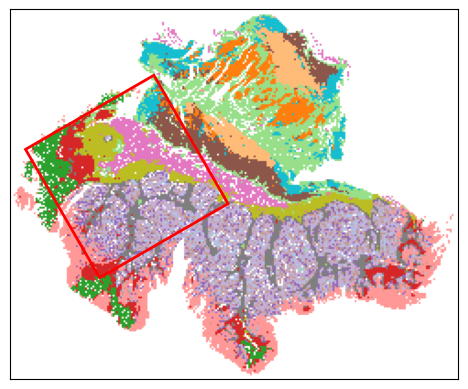

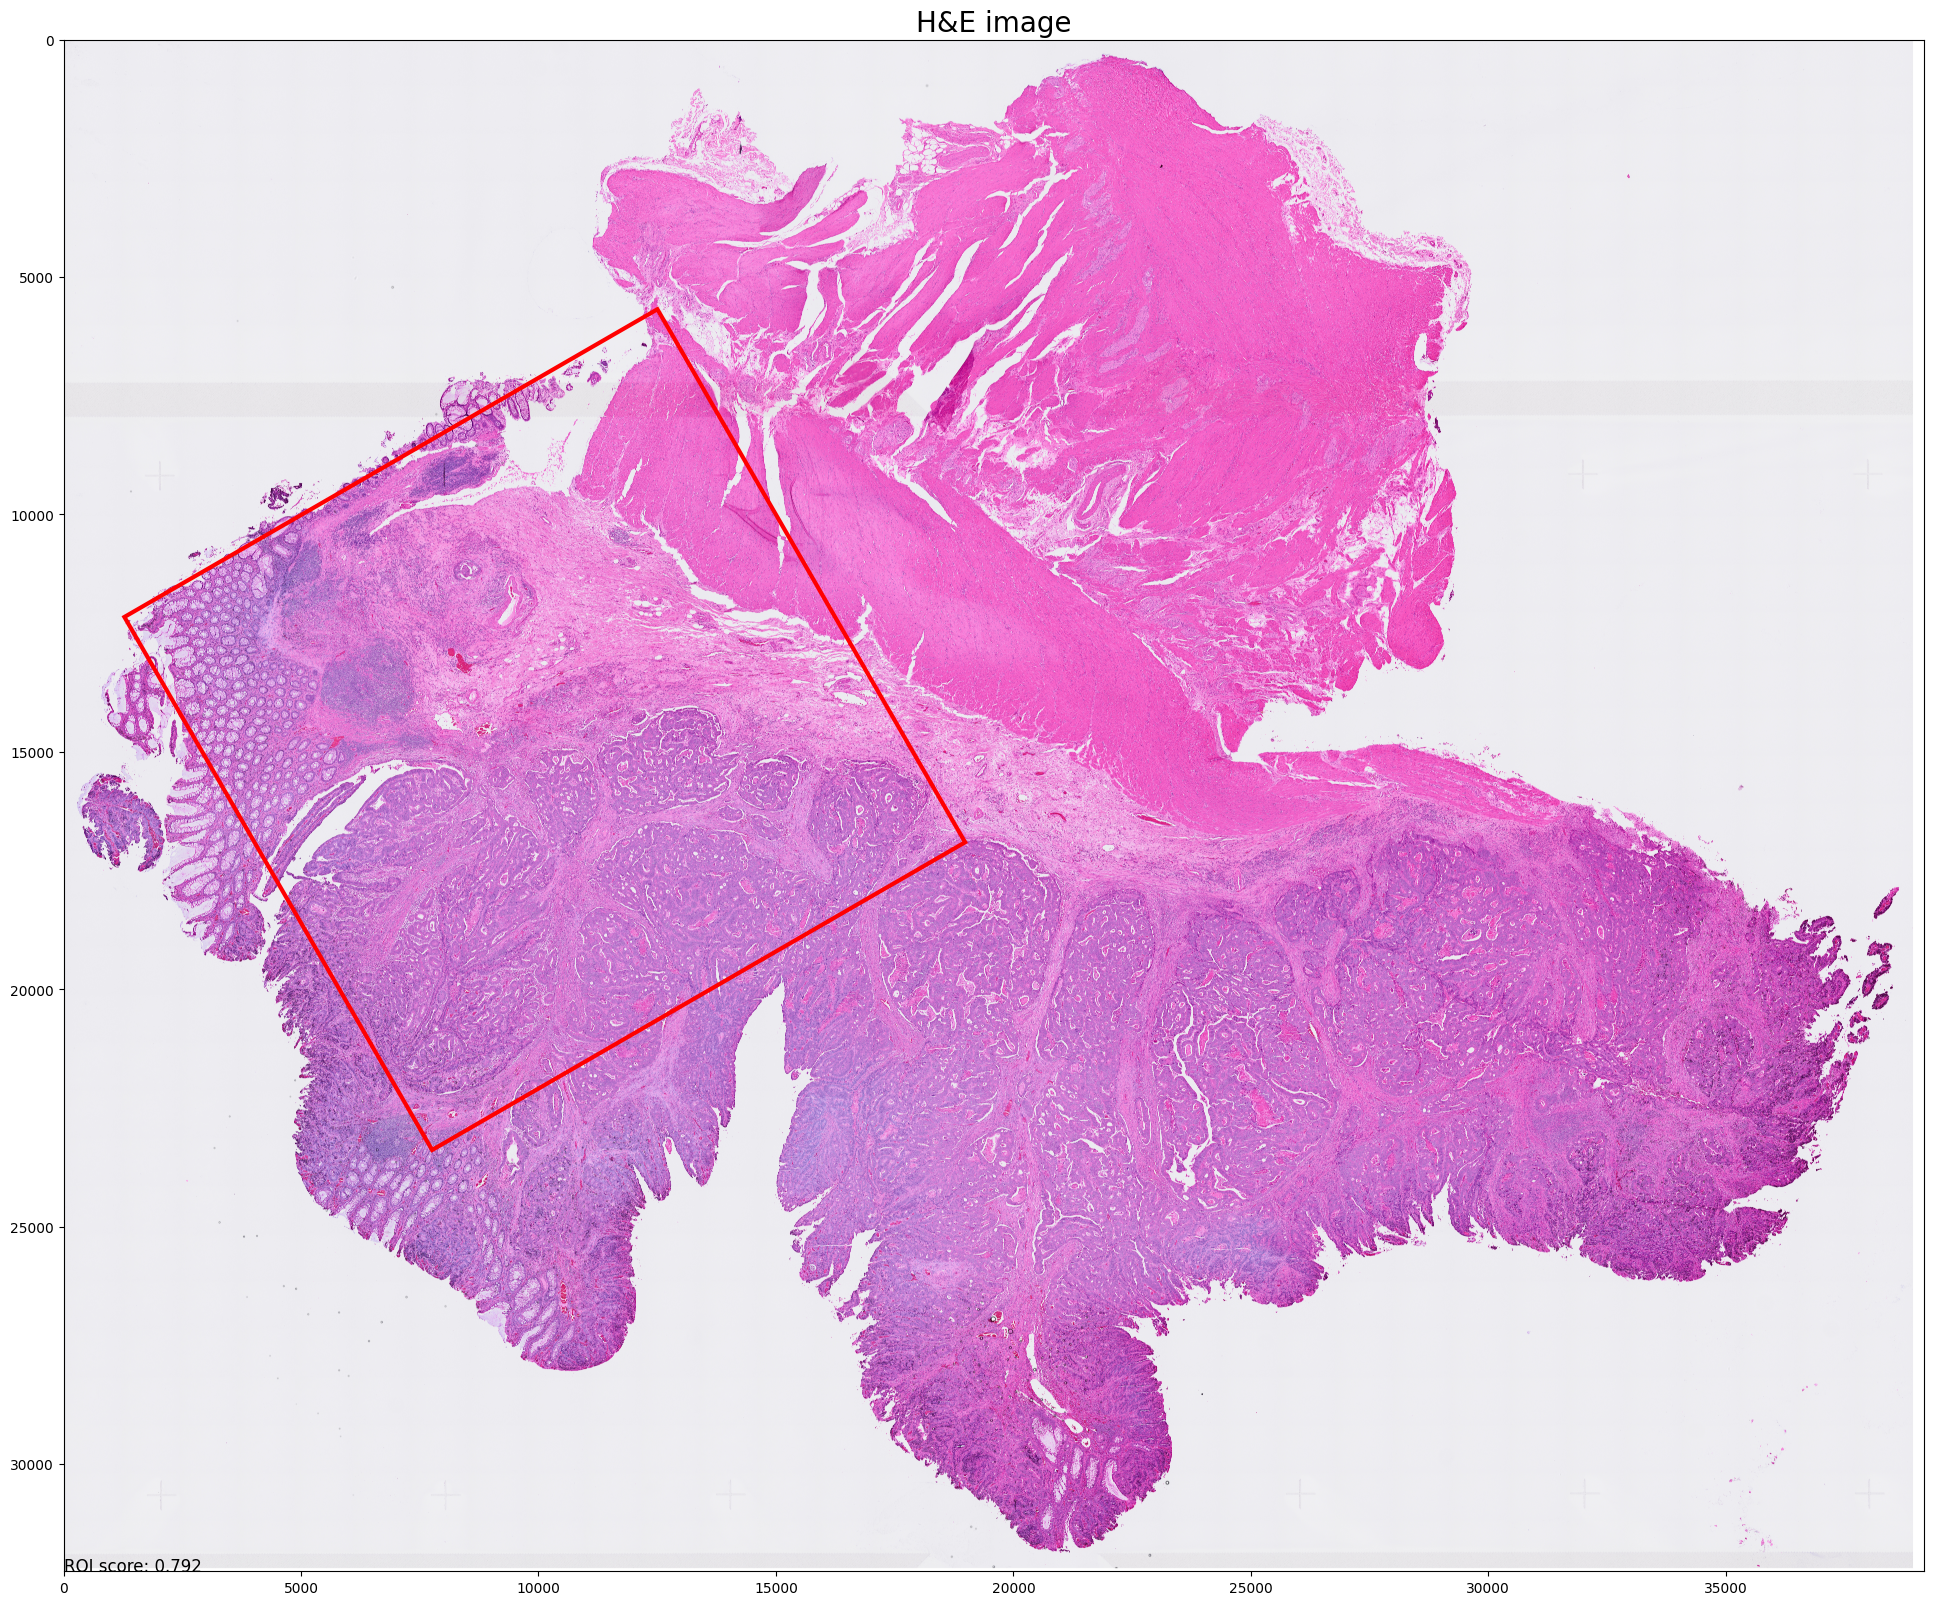

In [12]:
from s2omics.single_section.p6_roi_selection_rectangle import roi_selection_for_single_section

# fusion_weights: the weight of three scores, default=[0.33,0.33,0.33], the sum of three weights should be equal to 1 (if not they will be normalized)
# positive_prior, negative_prior: prior information about interested and not-interested histology clusters, default = [],[]
# prior_preference: the larger this parameter is, S2Omics will focus more on those interested histology clusters, default=  1
roi_selection_for_single_section(prefix, save_folder,
                                 down_samp_step=10,
                                 roi_size=[6.5,6.5],
                                 rotation_seg=6, 
                                 num_roi=1, #0 refers to automatiacally determine the number of ROI
                                 fusion_weights=[0.33,0.33,0.33],
                                 emphasize_clusters=[], discard_clusters=[],
                                 prior_preference=1)

# (Optional) Step 7: Cell type label broadcasting

** This step is based on the cell type label obtained from spatial omics experiment of selected ROI

** In this case (VisiumHD experiment design), the experiment can be conducted directly on the H&E slide, so we only need to broadcast the label from the ROI to the rest part of the slide

** But in many other situations, researchers may need to conduct experiment on another, adjacent slide, so we have to broadcast the label within the ROI from one slide to another slide.

**Notice: this step may cost a lot of time as we need to extract the histology features for each small superpixel**

In [ ]:
import sys
sys.path.append('..')
from s2omics.p3_feature_extraction import histology_feature_extraction

# down_samp_step: the down-sampling step, 
# default = 10 refers to only extract features for superpixels whose row_index and col_index can both be divided by 10 (roughly 1:100 down-sampling rate). 
# down_samp_step = 1 means extract features for every superpixel
histology_feature_extraction(prefix, save_folder,
                             foundation_model='uni',
                             ckpt_path='../checkpoints/uni/',
                             device='cuda:0',
                             batch_size=32,
                             down_samp_step=1,
                             num_workers=4)

In [ ]:
from s2omics.single_section.p7_cell_label_broadcasting import label_broadcasting

# SO_datapath is the path to spatial omics data folder which should contain preprocessed H&E image and annotation_file.csv
## if the H&E image is not preprocessed, please refer to step 1 and step 2
# WSI_datapath is the path to original whole slide H&E image
# this step is to transfer the cell type label inside the ROI of spatial omics data to the whole slide H&E image
label_broadcasting(WSI_datapath=prefix, WSI_save_folder=save_folder,
                   SO_datapath=prefix, SO_save_folder=save_folder,
                   WSI_cache_path='', SO_cache_path='',
                   foundation_model='uni', device='cuda:0')

Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/shapes.pickle
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/qc_preserve_indicator.pickle
Loading histology feature embeddings of the Spatial Omics data...
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/uni_embeddings_downsamp_1_part_0.pickle
Sucessfully loaded all histology feature embeddings of the Spatial Omics data!
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/shapes.pickle
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/qc_preserve_indicator.pickle
Loading histology feature embeddings of the whole-lide H&E data...
Pickle loaded from ../demo/Tutorial_1_VisiumHD_ROI_selection_colon/S2Omics_output/pickle_files/uni_embeddings_downsamp_1_part_0.pickle
Sucessfully loaded all histology feature embeddings 